After exploring the data and understanding that flavor profiles correspond with the overall ratings in a non-linear fashion, we can now turn our eyes towards predicting the ratings. We will be ambitious and attempt to predict the exact average rating of a beer. This makes this a regression problem. We will use a range of ML models to predict the ratings, starting at a simple linear regression and moving up in complexity towards a neural network. 

It should be said that based on the structure of the data, this should be a suitable problem for non-linear regression models. The data is not linearly separable, and the features are not linearly correlated with the target. 

After identifying the best-performing model, we will conduct hyperparameter tuning to improve the model's performance as much as possible.

First, let's load the required libraries and data.

In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

# Load the data
data = pd.read_csv('data/beer_profile_and_ratings.csv')
data = data[data['number_of_reviews'] >= 5] # Filter out beers with less than 5 reviews

Next, we split the data into training and test sets. We will use 80% of the data for training and 20% for testing. For now, we will only use the flavor information to predict the ratings. We might add other features later.

As the individual flavor ratings are on different scales, we will use sklearn's standard scaler to scale the data. We can use th standard scaler, because the underlying datapoints are normally distributed. 

In [4]:
#log transform response variables and replace -inf with 0
pv = np.log(data.iloc[:, [8,
                  9,
                  10,
                  11,
                  12,
                  13,
                  14,
                  15,
                  16,
                  17,
                  18]]) #log transform response variables
pv.replace([np.inf, -np.inf], 0, inplace=True) #replace -inf with 0

# Split the data into X (features) and y (target)
X = pv
y = data['review_overall']

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

As we will apply multiple algorithms to the data, we will write a bunch of functions to fit, evaluate, and plot the performance of the models. We will write various versions of the functions so we are a bit more flexible in how we evaluate the models.

Given that we are trying to predict a continuous variable, we will use the mean squared error (MSE) and the R2 score as our evaluation metrics (given that the number of predictors remains the same across models, we do not have to use the adjusted R2). To get a more intuitive feel of the precision of our predictions, we will also calculate an accuracy score. We will use the accuracy score as a measure of how close the predicted rating is to the actual rating. We will define the accuracy score as the absolute difference between the predicted and actual rating divided by the actual rating.

In [5]:
# Create a function that evaluates the performance of the model and saves the results to performance
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    r2 = 100 * r2_score(y_test, predictions)
    mse=mean_squared_error(y_test, predictions)
    print('Model Performance')
    print('Average Error: {:0.4f} rating points.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('R2 = {:0.2f}%.'.format(r2))
    print('MSE = {:0.2f}.'.format(mse))
    return accuracy, r2, mse

# Create a function that fits the model and evaluates the performance
def fit_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return evaluate(model, X_test, y_test)

# Create a function that fits the model, evaluates the performance and plots the residuals
def fit_evaluate_plot(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    r2 = 100 * r2_score(y_test, predictions)
    mse=mean_squared_error(y_test, predictions)
    print('Model Performance')
    print('Average Error: {:0.4f} rating points.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('R2 = {:0.2f}%.'.format(r2))
    print('MSE = {:0.2f}.'.format(mse))
    plt.scatter(y_test, errors)
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.show()

# Running the models
We are ready to go. Let's start with a simple linear regression model. Given that features are not linearly correlated with our outcome variable, we do not expect this model to perform very well. But let's see what happens.

Model Performance
Average Error: 0.2590 rating points.
Accuracy = 92.66%.
R2 = 27.96%.
MSE = 0.12.


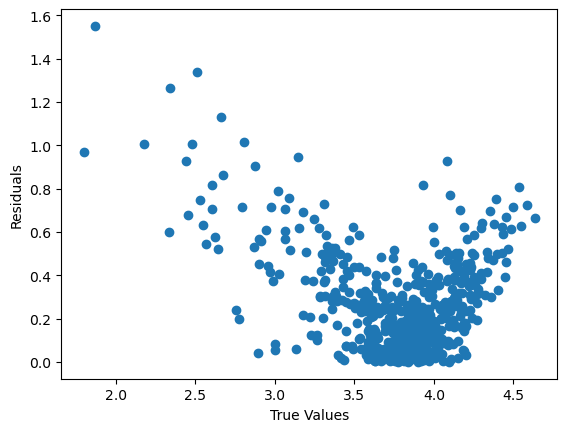

Model Performance
Average Error: 0.2590 rating points.
Accuracy = 92.66%.
R2 = 27.96%.
MSE = 0.12.


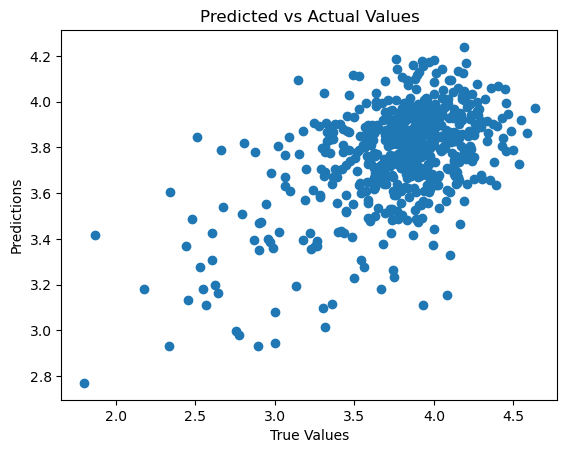

In [6]:
## Use various ML models to predict the rating of a beer based on the other features
# Create a dataframe to store the performance of the models
performance = pd.DataFrame(columns=['Accuracy', 'R2', 'MSE'])
# Start with a simple linear regression model
base_model = LinearRegression()
base_plot = fit_evaluate_plot(base_model, X_train, y_train, X_test, y_test)
#save the performance of the model to the performance dataframe
performance.loc['Linear Regression', :] = evaluate(base_model, X_test, y_test)

#Show predicted vs actual values
predictions = base_model.predict(X_test)
pred_true = pd.DataFrame({'True Values': y_test, 'Predictions': predictions})
plt.scatter(y_test, predictions)
plt.title( 'Predicted vs Actual Values' )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# Out of the box, the accuracy of a linear regression model is not bad, 92.44%. The residual plot shows that the model is not perfect, but it is not too bad either. 
# We can see that the model is off at the tail ends of the distribution, which is expected. Given that it is a linear regression model, the model will be biased to reduce the errors 
# in the ratings range with the highest density - after all it aims to reduce the average residuals.
# Therefore, predictions are best in the range between 3.5 and 4.


# Decision Tree

Model Performance
Average Error: 0.3317 rating points.
Accuracy = 90.69%.
R2 = -24.23%.
MSE = 0.20.


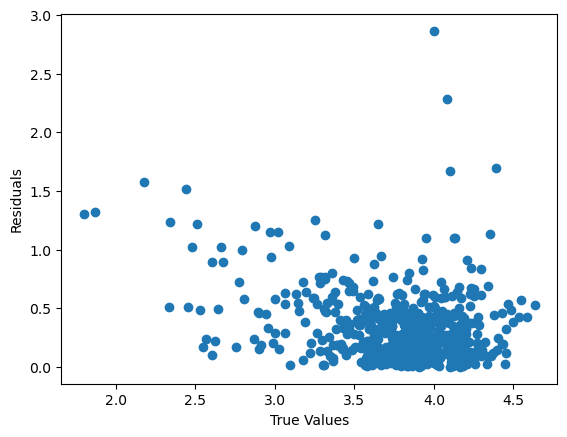

Model Performance
Average Error: 0.3317 rating points.
Accuracy = 90.69%.
R2 = -24.23%.
MSE = 0.20.


In [7]:
# Let's try a model that is not biased towards the mean - a decision tree
tree = DecisionTreeRegressor()
tree_plot = fit_evaluate_plot(tree, X_train, y_train, X_test, y_test)

# Errors are spread more evenly, but the model is not as accurate as the linear regression model. 
# Actually, it is doing worse than if we would just predict the mean of the target values (as shown by the negative R2 score).
#save the performance of the model to the performance dataframe
performance.loc['Decision Tree', :] = evaluate(tree, X_test, y_test)


# Random Forest

Model Performance
Average Error: 0.2420 rating points.
Accuracy = 93.14%.
R2 = 36.12%.
MSE = 0.10.


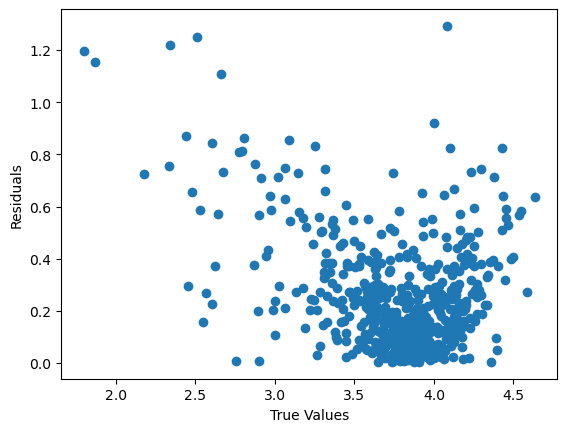

Model Performance
Average Error: 0.2420 rating points.
Accuracy = 93.14%.
R2 = 36.12%.
MSE = 0.10.


In [8]:
# Let's try a random forest model
forest = RandomForestRegressor()
forest_plot = fit_evaluate_plot(forest, X_train, y_train, X_test, y_test)
# we are getting better results, but the model is still biased towards the mean - but results are better than the linear regression model
#save the performance of the model to the performance dataframe
performance.loc['Random Forest', :] = evaluate(forest, X_test, y_test)


 # KNN

Model Performance
Average Error: 0.2365 rating points.
Accuracy = 93.31%.
R2 = 36.77%.
MSE = 0.10.


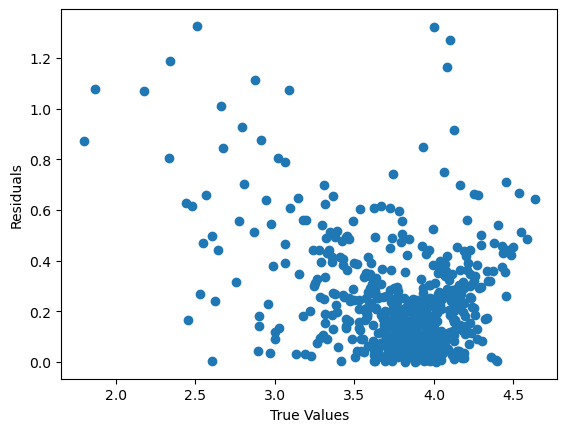

Model Performance
Average Error: 0.2365 rating points.
Accuracy = 93.31%.
R2 = 36.77%.
MSE = 0.10.


In [9]:
# Let's try a KNN model
knn = KNeighborsRegressor()
knn_plot = fit_evaluate_plot(knn, X_train, y_train, X_test, y_test)
# the model is not as accurate as the random forest model, but close
#save the performance of the model to the performance dataframe
performance.loc['KNN', :] = evaluate(knn, X_test, y_test)

# XGBoost Regressor

Model Performance
Average Error: 0.2558 rating points.
Accuracy = 92.77%.
R2 = 29.79%.
MSE = 0.12.


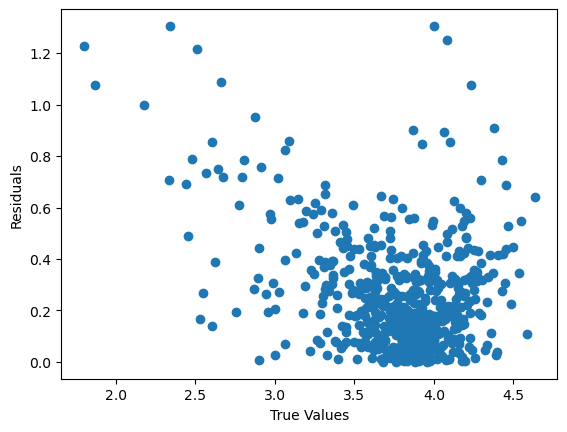

Model Performance
Average Error: 0.2558 rating points.
Accuracy = 92.77%.
R2 = 29.79%.
MSE = 0.12.


In [10]:
# Lets try XGBoostRegressor for a last check
import xgboost as xgb
xgb_model = xgb.XGBRegressor()
xgb_plot = fit_evaluate_plot(xgb_model, X_train, y_train, X_test, y_test)
#save the performance of the model to the performance dataframe
performance.loc['XGBoost', :] = evaluate(xgb_model, X_test, y_test)

# Support Vector Regressor (SVM)

Model Performance
Average Error: 0.2314 rating points.
Accuracy = 93.45%.
R2 = 42.17%.
MSE = 0.09.


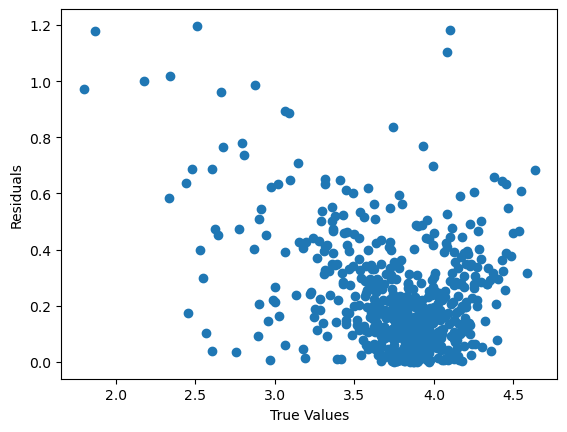

Model Performance
Average Error: 0.2314 rating points.
Accuracy = 93.45%.
R2 = 42.17%.
MSE = 0.09.


In [11]:
# Let's try a SVM model
svm = SVR()
svm_plot = fit_evaluate_plot(svm, X_train, y_train, X_test, y_test) 
# The best candidate. Still, errors are largest at the tail ends of the distribution, but less so than for the linear model. 
# This cn be explained by the fact that SVR is a non-linear regression algorithm that reduced residuals locally instead of globally.
#save the performance of the model to the performance dataframe
performance.loc['SVM', :] = evaluate(svm, X_test, y_test)

# Neural Network
Just for completeness, let's check how a neural network performs on this problem. We will use a simple neural network with one hidden layer. We will use the Adam optimizer and the mean squared error as the loss function. We will use the same training and test sets as before.

In [12]:
# Create a neural network model to predict the ratings
from keras.models import Sequential 
from keras.layers import Dense

# create a neural network to predict the ratings

model = Sequential()
# add the input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# add a hidden layer
model.add(Dense(32, activation='relu'))
# add the output layer - linear activation, as our outcome variable is continuous
model.add(Dense(1, activation='linear'))
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
# evaluate the model
model.evaluate(X_test, y_test)


# calculate model performance manually, because keras format is different from sklearn
predictions = model.predict(X_test)
errors = abs(predictions[:,0] - y_test)
mape = 100 * np.mean(errors / y_test)
accuracy = 100 - mape
r2 = 100 * r2_score(y_test, predictions)
mse=mean_squared_error(y_test, predictions)
print('Model Performance')
print('Average Error: {:0.4f} rating points.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))
print('R2 = {:0.2f}%.'.format(r2))
print('MSE = {:0.2f}.'.format(mse))

# Save performance 
performance.loc['NeuralNet', :] = [accuracy, r2, mse]

19/19 [==============================] - 0s 2ms/step
Model Performance
Average Error: 0.2668 rating points.
Accuracy = 92.49%.
R2 = 23.09%.
MSE = 0.13.


# Compare the performance of the models

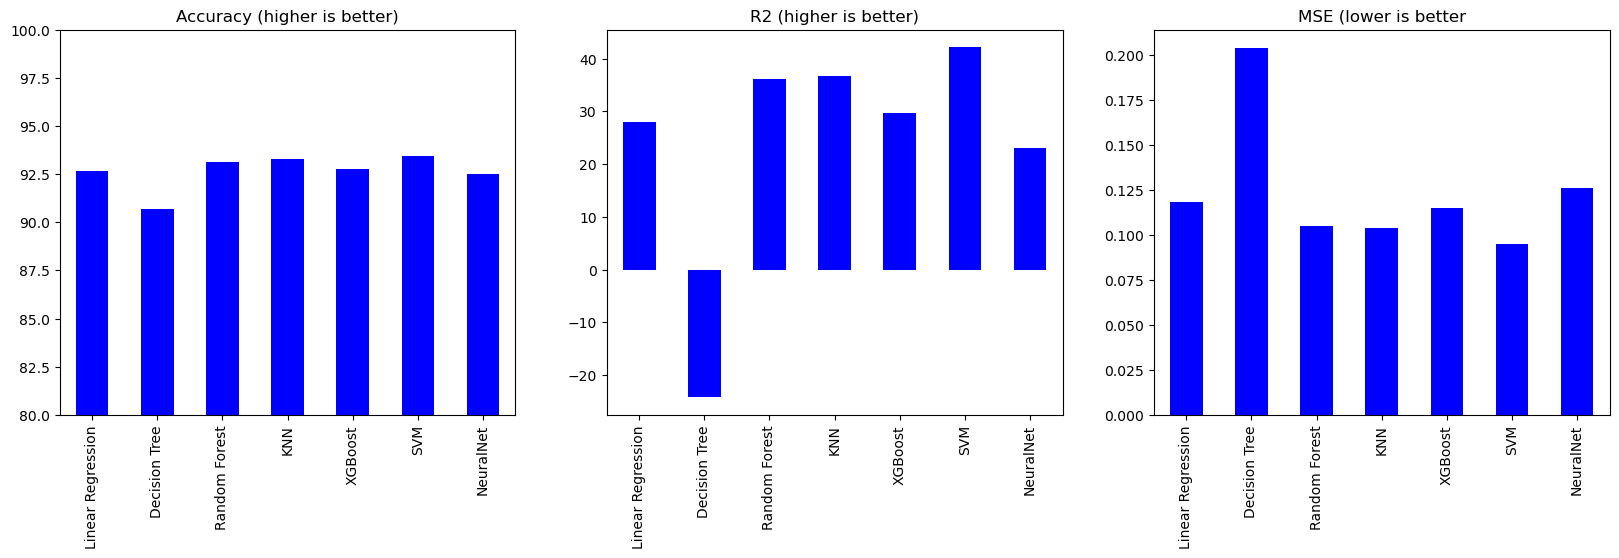

In [13]:
# create an empty plot with 3 subplots and fill the subplots with the plots of the models: accuracy, R2 and MSE.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
performance['Accuracy'].plot(kind='bar', ax=ax1, color='blue', ylim=(80,100))
performance['R2'].plot(kind='bar', ax=ax2, color='blue')
performance['MSE'].plot(kind='bar', ax=ax3, color='blue')
ax1.set_title('Accuracy (higher is better)')
ax2.set_title('R2 (higher is better)')
ax3.set_title('MSE (lower is better')
plt.show()

From this comparison, we can see that the supprt vector regressor performs the best. Lets try toimprove the performance of this model by tuning the hyperparameters.

# Hyperparameter tuning

In [15]:
param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma' : ['scale', 'auto']
}
# Create a based model
svm = SVR()
# Instantiate the random search model
random_search = RandomizedSearchCV(estimator = svm, param_distributions = param_grid, n_iter = 50, cv = 3, verbose=3, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the grid search to the data
random_search.fit(X_train, y_train)
# Evaluate the model
evaluate(random_search, X_test, y_test)
# what are the parameters of the best model?
random_search.best_params_ # conveniently, the standard parameters of the SVM model are the best parameters

C:\Users\motru\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Model Performance
Average Error: 0.2314 rating points.
Accuracy = 93.45%.
R2 = 42.17%.
MSE = 0.09.


{'kernel': 'rbf', 'gamma': 'auto', 'C': 1}

It turns out that the default hyperparameters of the support vector regressor perform the best. Let's have a look at the feature importances of the model.

Text(0.5, 0, 'Permutation Importance')

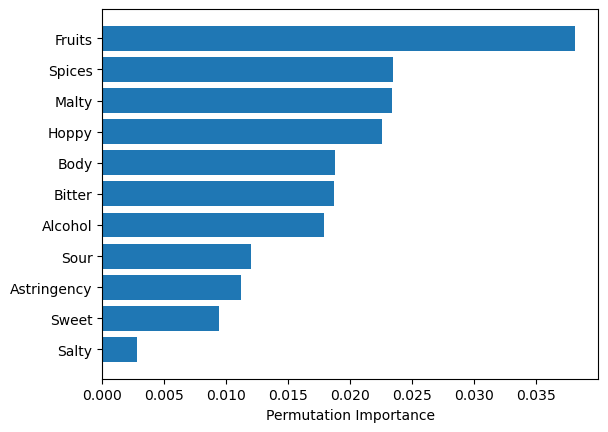

In [16]:
# extract the feature importances from the svm model
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(random_search, X_test, y_test)
perm_importance
feature_names = data.iloc[:, [8,
                  9,
                  10,
                  11,
                  12,
                  13,
                  14,
                  15,
                  16,
                  17,
                  18]].columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

We can now produce predictions for the full dataset. Lastly, we will use the full dataset to train the SVR regressor and predict the ratings of all the beers in our dataset. This will increase the training dataset and should further improve the performance of the model for future predictions. Of course, we would need to constantly reevaluate how our prediction model is doing, by comparing predictions against the actual ratings. 

In [21]:
# predict the full dataset
predictions = random_search.predict(scaler.transform(pv))
# add the predictions to the dataframe
data['Predicted Rating'] = predictions

#and now train the model on the full dataset
random_search.fit(scaler.transform(pv), data['review_overall'])

# and predict the ratings for the full dataset
predictions_2 = random_search.predict(scaler.transform(pv))
# add the predictions to the dataframe
data['Predicted Rating 2'] = predictions_2


C:\Users\motru\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 24 candidates, totalling 72 fits


# Plot the final results
With the two rounds of predictions in (trained on smaller training data and trained on full data), let's compare the results. For both models we see that the performance is quite good. The model trained on the full dataset performs slightly better, due to the larger training size and due to the fact that we evaluate the model on the data it was trained on. As I said, we will see the real performance of the model when we test it against future ratings as they come in.

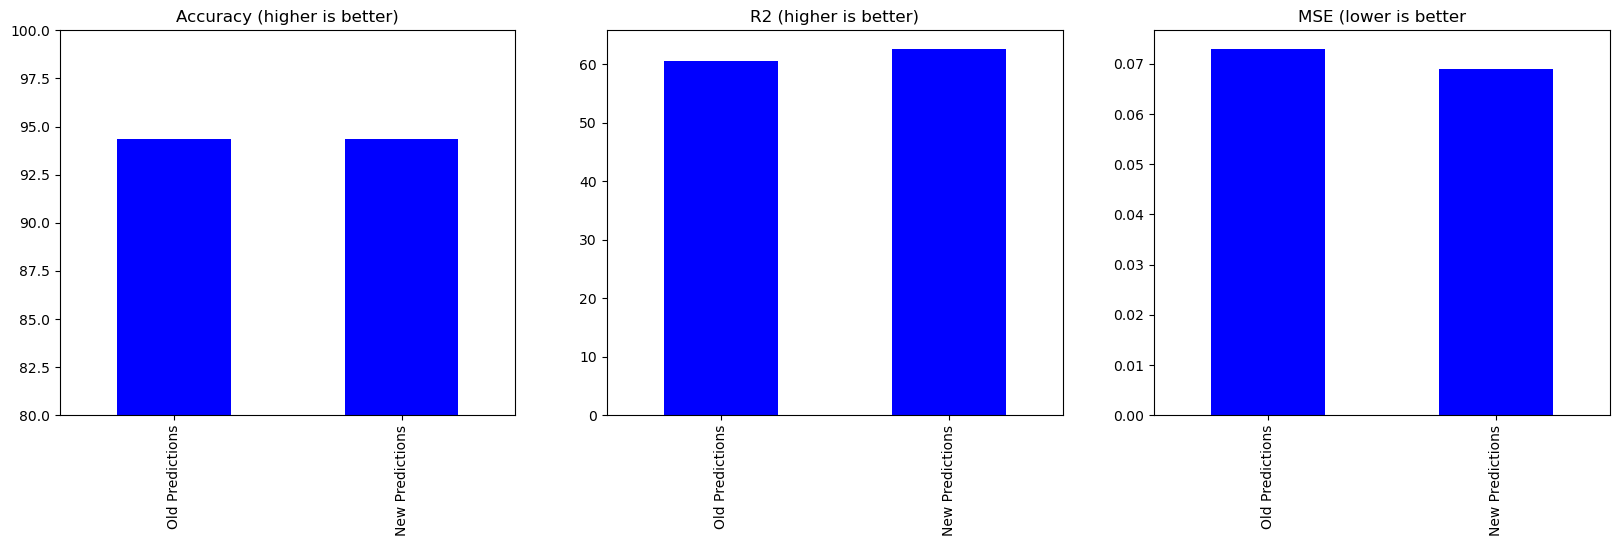

In [22]:
# compare old and new predictions and actual values
comparison = pd.DataFrame({'Old Predictions': predictions, 'New Predictions': predictions_2, 'Real Values': data['review_overall']})

#calculate model performance for the old and new predictions
errors = abs(predictions - data['review_overall'])
mape = 100 * np.mean(errors / data['review_overall'])
accuracy = 100 - mape
r2 = 100 * r2_score(data['review_overall'], predictions)
mse=mean_squared_error(data['review_overall'], predictions)

errors_n = abs(predictions_2 - data['review_overall'])
mape_n = 100 * np.mean(errors / data['review_overall'])
accuracy_n = 100 - mape
r2_n = 100 * r2_score(data['review_overall'], predictions_2)
mse_n=mean_squared_error(data['review_overall'], predictions_2)

# vizualize the two model performances
performance = pd.DataFrame({'Accuracy': [accuracy, accuracy_n], 'R2': [r2, r2_n], 'MSE': [mse, mse_n]}, index=['Old Predictions', 'New Predictions'])
# plot the performance of the three indicators in three separate windows
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
performance['Accuracy'].plot(kind='bar', ax=ax1, color='blue', ylim=(80,100))
performance['R2'].plot(kind='bar', ax=ax2, color='blue')
performance['MSE'].plot(kind='bar', ax=ax3, color='blue')
ax1.set_title('Accuracy (higher is better)')
ax2.set_title('R2 (higher is better)')
ax3.set_title('MSE (lower is better')
plt.show()

By increasing the training data size, we furthermore improved our predictions. While the accuracy remained the same, we could meaningfully increase the R2 and reduce the MSE. From manually checking the data, we can also see that the new predictions are getting closer to the actual ratings.

# Conclusion
In this notebook, we explored the BeerAdvocate dataset and used it to predict the average rating of a beer. We used a range of ML models to predict the ratings, starting at a simple linear regression and moving up in complexity towards a neural network. We found that the support vector regressor performed the best. We then tuned the hyperparameters of the support vector regressor to improve the model's performance. We were able to increase the R2 and reduce the MSE by increasing the training data size.

This leaves us with a predictor that lets us judge the perception of a new beer with fairly high confidence. There are a number of other applications of this work. For instance, we could build a recommender system that recommends beers based on the flavor profile of the beer. If a user likes a certain beer, we could use cosine similarity to find beers with similar flavor profiles.

Of course, there are other ways of improving our predictions. We could bring in more infromation about the beers, for instance the beer type, the brewery, the alcohol content, and so on. However, as we wanted to focus on predicting beer reception by flavor profiles, we shall leave these ideas for another time.

Cheers!
